In [33]:
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import plotly.graph_objects as go

import numpy as np

In [34]:
listings = pd.read_csv('Cincy_all_listings_2023_11_14.csv')

/var/folders/_3/v349phgn4ljd3jkf3ll9p2cm0000gp/T/ipykernel_74496/1213032299.py:1: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.



In [35]:
raw = []
for i in range(13):
    raw.append(pd.read_csv(f'cincy_all_listings{i}.csv'))
raw = pd.concat(raw)

In [36]:
api = pd.read_csv('results.csv')
api.head()

,process_id,mls_id,status
0,18781,507509,Closed
1,18780,535235,Closed
2,18782,507537,Closed
3,18783,537296,Closed
4,18784,538869,Closed


In [37]:
def get_listing_id(id):
    if pd.isna(id):
        return 0
    try:
        return int(id)
    except:
        return int(id.split('-')[1])
    
listings['rebny_id'] = [get_listing_id(x) for x in listings['rebny_id']]

In [38]:
only_in_raw = raw[~raw['listing_id'].isin(listings['rebny_id'])]
in_listings = raw[raw['listing_id'].isin(listings['rebny_id'])]

In [39]:
#api[api['status'] == 'ERROR'] = 'not in API'

In [40]:
api.groupby('status')['mls_id'].nunique()

status
Active           3632
Canceled       171947
Closed         752228
Coming Soon         2
ERROR               8
Expired        282620
Hold             2132
Pending          2239
Withdrawn           8
Name: mls_id, dtype: int64

In [42]:
graph = {'source': ['from_pw_ui', 'seen_objects', 'seen_objects'], 
         'target': ['listings', 'listings', 'not_in_listings'],
         'weight': [len(listings[~listings['rebny_id'].isin(raw['listing_id'])]), in_listings['listing_id'].nunique(), only_in_raw['listing_id'].nunique()]}
graph

{'source': ['from_pw_ui', 'seen_objects', 'seen_objects'],
 'target': ['listings', 'listings', 'not_in_listings'],
 'weight': [8450, 1207827, 17]}

In [43]:
api_response = api.groupby('status')['mls_id'].nunique()
for i in range(len(api_response)):
    graph['source'].append('listings')
    graph['weight'].append(api_response[i])
    graph['target'].append(api_response.index[i])

print(len(graph['source']), len(graph['weight']), len(graph['target']))

12 12 12


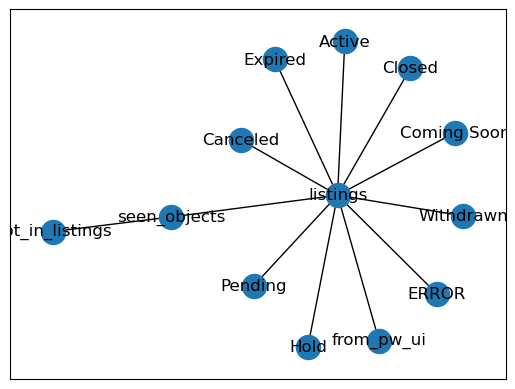

In [44]:
G = nx.from_pandas_edgelist(pd.DataFrame(graph))
nx.draw_networkx(G, arrows=True, with_labels=True)
plt.show()

In [45]:
def sandkey(df:pd.DataFrame, flow_cat:list,
             weight_col:str,
             title:str='Data_Flow',
               pd_calc:str='sum',
                 save_chart=False):
    """Create sandkey plot.

    Args:
        df (pd.DataFrame): Data
        flow_cat (list): Columns to use as flow.
        weight_col (str): Column used for flow
        title (str, optional): Chart Title. Defaults to 'Flow Diagram'.
        pd_calc (str, optional): Summary calculation. Defaults to 'sum'.
    
    Example:
    category = ['start', 'state_type','lat_lon', 'land_type','action']

    sandkey(df, flow_cat=category,weight_col='num')

    """
    '''data_lst = []
    for i in range(len(flow_cat)-1):

        temp_df = df[[flow_cat[i],flow_cat[i+1],weight_col]]
        temp_df.columns = ['source','target', weight_col]
        data_lst.append(temp_df)
    data = pd.concat(data_lst)'''    
    data = df.groupby(['source','target']).agg(weight=(weight_col,pd_calc)).reset_index()
    label_list = list(np.unique(df[flow_cat].values))

    fig = go.Figure(data=[go.Sankey(
        node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label =label_list,
        color = "blue"
        ),
        link = dict(
            source = data['source'].apply(lambda x: label_list.index(x)),
            target = data['target'].apply(lambda x: label_list.index(x)),
            value = data['weight'].values.tolist()
    ))])
    fig.update_layout(title_text=title, font_size=10)
    if save_chart:
          fig.write_html(title+'.html')
    fig.show()


In [46]:
label_list = ['from_pw_ui', 'seen_objects', 'listings', 'not_in_listings', 'Active', 'Coming Soon', 'Withdrawn', 'Canceled', 'Expired', 'Closed', 'Hold', 'Pending', 'ERROR']
#sandkey(pd.DataFrame(graph), flow_cat=category, weight_col='weight')

In [47]:
data = pd.DataFrame(graph)
fig = go.Figure(data=[go.Sankey(
        node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label =label_list,
        color = "blue"
        ),
        link = dict(
            source = data['source'].apply(lambda x: label_list.index(x)),
            target = data['target'].apply(lambda x: label_list.index(x)),
            value = data['weight'].values.tolist()
    ))])

fig.show()
fig.write_html('Cincy Data Audit.html')

In [ ]:
api[api['status'] == 'ERROR']

,process_id,mls_id,status
11021,23208,1789276,ERROR
22336,23210,1788865,ERROR
30765,23209,1788030,ERROR
98667,41680,1787932,ERROR
105769,41679,1788053,ERROR
152412,53419,1785849,ERROR
689458,53415,1786014,ERROR
1115701,53416,1786687,ERROR


In [ ]:
len(raw)

1207844

In [ ]:
len(set(listings['id']))

1229029

In [ ]:
len(api)

1214818